# Simple running example of DAHSI

In this notebook we will show a simple running example of the DAHSI algorithm presented in the paper ... 

## Generating the data

We will work with the Lorenz system as it is a classical example of chaotic systems.

The data we will use for showing a simple running example will be comprised of $N = 501$ time points, with $\Delta t = 0.01$ and noise ...

To make this example simpler, we will consider all variables observed.

The library function is defined in $\texttt{File1.txt}$ ...

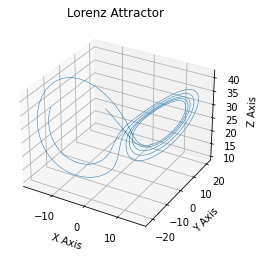

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def fx(x,y,z,t): return sigma*(y-x)
def fy(x,y,z,t): return x*(rho-z)-y
def fz(x,y,z,t): return x*y-beta*z

def RungeKutta45(x,y,z,fx,fy,fz,t,h):
    k1x,k1y,k1z = ( h*f(x,y,z,t) for f in (fx,fy,fz) )
    xs, ys,zs,ts = ( r+0.5*kr for r,kr in zip((x,y,z,t),(k1x,k1y,k1z,h)) )
    k2x,k2y,k2z = ( h*f(xs,ys,zs,ts) for f in (fx,fy,fz) )
    xs, ys,zs,ts = ( r+0.5*kr for r,kr in zip((x,y,z,t),(k2x,k2y,k2z,h)) )
    k3x,k3y,k3z = ( h*f(xs,ys,zs,ts) for f in (fx,fy,fz) )
    xs, ys,zs,ts = ( r+kr for r,kr in zip((x,y,z,t),(k3x,k3y,k3z,h)) )
    k4x,k4y,k4z  =( h*f(xs,ys,zs,ts) for f in (fx,fy,fz) )
    
    return (r+(k1r+2*k2r+2*k3r+k4r)/6 for r,k1r,k2r,k3r,k4r in 
            zip((x,y,z),(k1x,k1y,k1z),(k2x,k2y,k2z),(k3x,k3y,k3z),(k4x,k4y,k4z)))

xfile = open("datax_Lorenz.dat", "w")
yfile = open("datay_Lorenz.dat", "w")
zfile = open("dataz_Lorenz.dat", "w")

sigma=10.
beta=8./3.
rho=28.
tIn=0.
tFin=5.04
h=0.01
# totalSteps=int(np.floor((tFin-tIn)/h))
totalSteps=502

t = totalSteps * [0.0]
x = totalSteps * [0.0]
y = totalSteps * [0.0]
z = totalSteps * [0.0]

x[0],y[0],z[0],t[0] = -8.0, 7.0, 27.0, 0.  #Initial condition
for i in range(1, totalSteps):
    x[i],y[i],z[i] = RungeKutta45(x[i-1],y[i-1],z[i-1], fx,fy,fz, t[i-1], h)
    
    xfile.write("%.5f\n"%x[i])
    yfile.write("%.5f\n"%y[i])
    zfile.write("%.5f\n"%z[i])

xfile.close()    
yfile.close()    
zfile.close()    
# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(x, y, z, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()    

In [23]:
!python compile.py


Defining the objective function...

	It takes 0.127941 seconds to create the objective function for a general time point.


Defining the Jacobian...

	It takes 0.457823 seconds to create the Jacobian for a general time point.


Defining the Hessian...

	It takes 2.107137 seconds to create the Hessian for a general time point.

	There's a total of 20287 non-zeros in the full Hessian.


Total time: 4.929519 seconds.


	The strings were successfully written in the Cython file.

running build_ext
cythoning OneLoopInC.pyx to OneLoopInC.c
building 'OneLoopInC' extension
gcc -pthread -B /home/user/anaconda3/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/user/anaconda3/include -I/home/user/anaconda3/include -fPIC -O2 -isystem /home/user/anaconda3/include -fPIC -I/home/user/anaconda3/include/python3.9 -c OneLoopInC.c -o build/temp.linux-x86_64-3.9/OneLoopInC.o -ffast-math
gcc -pthread -B /home/user/anaconda3/compiler_compat -shared -Wl,-rpath,/hom

Now that we have the data, we start by importing all the modules and functions needed to run our code.

In [2]:
from header import *

import pyximport
pyximport.install()

from PyIpopt_Funks import *

import time

import pickle 

import os

import OneLoopInC

from OneLoopInC import eval_f_tricky

from OneLoopInC import eval_grad_f_tricky

from OneLoopInC import eval_h_tricky

In [3]:
# We load the variables needed from ObjNeed.obj created in Define_JacHess.py
file_ObjJacHess = open('ObjJacHess.obj', 'rb') 

ObjFunk_Meas_eval = pickle.load(file_ObjJacHess)
ObjFunk_Model_eval = pickle.load(file_ObjJacHess)
Jacobian_Meas = pickle.load(file_ObjJacHess)
Jacobian_Model = pickle.load(file_ObjJacHess)
Hessian_Meas = pickle.load(file_ObjJacHess)
Hessian_Model = pickle.load(file_ObjJacHess)
row_final = pickle.load(file_ObjJacHess)
col_final = pickle.load(file_ObjJacHess)
nnzh = pickle.load(file_ObjJacHess)

def eval_f(x):
    assert len(x) == num_total
    
    return eval_f_tricky(x,Rf)

def eval_grad_f(x):
    assert len(x) == num_total
    
    return eval_grad_f_tricky(x,Rf)
    
def eval_h(x,lagrange,obj_factor,flag):
    if flag:
        return (np.array(col_final),np.array(row_final))
    else:
        return eval_h_tricky(x,lagrange,obj_factor,flag,Rf)
        
class DAHSI():
    def objective(self, x):
        """Returns the scalar value of the objective given x."""
        return eval_f_tricky(x,Rf)

    def gradient(self, x):
        """Returns the gradient of the objective with respect to x."""
        return np.transpose(eval_grad_f_tricky(x,Rf))

    def constraints(self, x):
        """Returns the constraints."""
        return array([ ], float_)

    def jacobian(self, x):
        """Returns the Jacobian of the constraints with respect to x."""
        return np.array([])

    def hessianstructure(self):
        """Returns the row and column indices for non-zero vales of the
        Hessian."""

        # NOTE: The default hessian structure is of a lower triangular matrix,
        # therefore this function is redundant. It is included as an example
        # for structure callback.

#        return np.nonzero(np.tril(np.ones((num_total, num_total))))    
        return (np.array(col_final),np.array(row_final))

    def hessian(self, x, lagrange, obj_factor):
        """Returns the non-zero values of the Hessian."""        
        H = eval_h_tricky(x,lagrange,obj_factor,0,Rf)        

        row, col = self.hessianstructure()

        return H

In [4]:
# Choose seed for random number generation.
IC = 99
np.random.seed(IC)

# Bounds for both state variables and parameters. 
x_L = np.ones((num_total))
x_U = np.ones((num_total))

for i in range(num_vars):
    x_L[i:-num_params:num_vars] = float(Input1[1+2*num_vars+num_params+i].split(",")[0])
    x_U[i:-num_params:num_vars] = float(Input1[1+2*num_vars+num_params+i].split(",")[1])
for i in range(num_params):
    x_L[-num_params+i] = float(Input1[1+3*num_vars+num_params+i].split(",")[0])
    x_U[-num_params+i] = float(Input1[1+3*num_vars+num_params+i].split(",")[1])

In [25]:
file_name = "D%s_M%s_IC%s_Lorenz.dat" % (num_vars, num_meas, IC) 
file_results = os.path.join("outputfiles",file_name)
f = open(file_results,"w+")

lambd = lambd_0

x_jp = np.zeros((num_total))    

# Use appropriate initial conditions: for state variables, random; for parameters, set them all to 0.
x0 = (x_U-x_L)*np.random.rand(num_total)+x_L      
for i in range(num_meas):
    for k in range(0,num_vars*num_tpoints,num_vars):
        x0[k+i] = data[int(k/num_vars),i] 
for i in range(num_params):    
    x0[i-num_params] = 0
        
for i in range(num_total):
    x_jp[i] = x0[i]

lb = x_L
ub = x_U

cl = np.array([])
cu = np.array([])

nlp = cyipopt.Problem(
   n=num_total,
   m=0,
   problem_obj=DAHSI(),
   lb=lb,
   ub=ub,
   cl=cl,
   cu=cu,
)

# Change some options of the solver.
nlp.add_option('linear_solver', 'ma97')
#nlp.add_option('max_iter',100)
#nlp.add_option('tol',1.e-12)
nlp.add_option('mu_strategy', 'adaptive')
nlp.add_option('adaptive_mu_globalization', 'never-monotone-mode')
#nlp.add_option('bound_relax_factor', 0)
# nlp.add_option('print_frequency_iter', 10000)
# nlp.add_option('print_info_string', 'no')
# nlp.add_option('output_file','output_ipopt.txt')
nlp.add_option('print_level',0)

5.618776144490107e-10
1.1014804308366912e-09
2.1192858533923892e-09
3.941523553982349e-09
6.9269050471912264e-09
1.1211244454743502e-08
1.6460325219181942e-08
2.213635612389942e-08
2.8136248302252538e-08
3.487677931923185e-08
4.270162925674127e-08
5.1347837883601817e-08
6.000916372145831e-08
6.788097253417901e-08
7.460829368208951e-08
8.031071238803811e-08
8.532892308698694e-08
9.002181095714044e-08
9.473123026490801e-08
9.99125697289939e-08
1.0496781428475448e-07
1.1070553058172488e-07
1.1576769850007629e-07
1.197440277444111e-07
1.2239699994720926e-07
1.2399853991659234e-07
1.2487945406646532e-07
1.2535112013333123e-07
1.255933936368853e-07
1.2571574068297952e-07
1.2577762803936552e-07


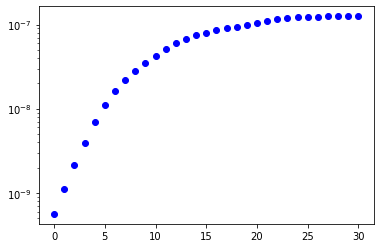

In [28]:
# Here starts the main loop
while lambd < lambd_max:   
    f = open(file_results,"a+")
	
    Rf0 = 1e-2

    for i in range(num_total):
        x_jp[i] = x0[i]    

    ax = plt.figure()
    for beta in range(beta_max+1):
        f = open(file_results,"a+")
        # Make note in results file which \lambda and \beta we are at.
        f.write("%f %f " % (lambd, beta))        

        # Controlling how much the model is enforced.
        Rf = Rf0*(alpha**beta)
  
        # Solve it via IPOPT (solution is x_jn).    
        x_jn, info = nlp.solve(x_jp)
            
        obj = info['obj_val']
        
        # We hard threshold the parameter part of the solution (the last num_params elements).
        for i in range(num_params):
    	    if abs(x_jn[i-num_params]) < lambd:
    	        x_jn[i-num_params] = 0

        # We set this solution as the initial condition for the next iteration of IPOPT. 
        x_jp = x_jn   

        # Write cost function value in file.
        f.write("%e " % obj)
        print(obj)
        
        plt.semilogy(beta, obj, 'bo')
        
        #for k in range(num_total):
        #    f.write("%f " % x_jp[k])
        #f.write("\n")  

        for k in range(num_params):
    	    f.write("%f " % x_jp[k-num_params])
        f.write("\n")     

        f.close()

    # Increase \lambda value.       
    lambd = lambd+0.5
f.close()    

plt.show()